### NLP APPS GROUP 80-
1. MANI SUNDER - 2022ac05010
2. GOPALAKRISHNA UPADHYAYA - 2022ac05306
3. PIUSH SINGH - 2022ac05433
4. VARISH TRIPATHI - 2022ac05404

### Important notes about the code
1. We chose 4 types of datasets for this assignment-
   - Research papers from Pubmed Central (in PDF) fomat
   - Drug (medicine) related articles (in .txt format) from a reputed website in the medical domain-  Healthline.com
   - Ariticles related to various Health condtions(in .txt format) again extrated from Healthline.com
   - Wikipedia articles(in .txt format) on some commonly searched topics online.
2. We used `BeautifulSoup` and `Selenium` to automatically extract the articles and the research papers.
3. We used `NLTK` and `Spacy` to extract the text from this corpus.
4. Once the preprocessing is done we used `valhalla/t5-small-e2e-qg` a transformers based LLM from hugging face to convert the pre-processed text into training data.
5. Used RoBERTa `deepset/roberta-base-squad2` for training the QA bot and the finetuned model is saved as `fine_tuned_roberta`
6. Models have been taken from `huggingface.com`

# 1. Importing Libraries

In [3]:
import requests
from bs4 import BeautifulSoup
import wikipediaapi
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException, NoSuchElementException
import urllib.parse
import re
import nltk
import spacy
from PyPDF2 import PdfReader
import pandas as pd
from multiprocessing import Pool
import warnings
import json
import concurrent.futures
from tqdm import tqdm  # For progress bar
from transformers import Trainer, TrainingArguments, RobertaForQuestionAnswering
from datasets import Dataset

_____________________________________________________________________________________________________________________________________________

## 2. Extracting Research Articles from PUBMED Central:
#### 2.a Defining the helper functions for extraction

In [8]:
# Base download directory
base_download_dir = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/PMC_Papers"

# Set up the WebDriver
service = Service('/usr/local/bin/chromedriver')

# Keywords to search for
keywords = [
    "medicine",
    "Medical Diagnosis",
    "Healthcare Informatics",
    "Clinical Guidelines",
    "Patient Treatment Protocols",
    "Disease Symptoms",
    "Medical Case Studies",
    "Pharmacology and Drug Information",
    "Surgical Procedures",
    "Epidemiology",
]

def setup_driver(download_dir): #setting up Chromedriver for data extraction
    chrome_options = Options()
    chrome_options.add_experimental_option('prefs', {
        "download.default_directory": download_dir,
        "download.prompt_for_download": False, 
        "download.directory_upgrade": True,  #
        "plugins.always_open_pdf_externally": True  # It will not show PDF directly in chrome
    })
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def download_pdfs(base_url, keyword, total_pages):
    keyword_dir = os.path.join(base_download_dir, keyword)
    os.makedirs(keyword_dir, exist_ok=True)
    
    # Setup the WebDriver with the new download directory
    driver = setup_driver(keyword_dir)
    wait = WebDriverWait(driver, 20)  # Increased wait time to ensure the page loads when trying to access PDFs

    search_url = f"{base_url}{urllib.parse.quote_plus(keyword)}"
    driver.get(search_url)
    
    for page in range(1, total_pages + 1):
        print(f"Processing page {page} for keyword '{keyword}'")

        # Wait for the PDF links to be present
        pdf_links_locator = (By.XPATH, "//a[contains(text(), 'PDF')]")
        wait.until(EC.presence_of_element_located(pdf_links_locator))

        # Find all PDF download links
        links = driver.find_elements(*pdf_links_locator)
        print(f"Found {len(links)} PDF links on page {page}")

        for index, link in enumerate(links):
            retries = 3
            while retries > 0:
                try:
                    pdf_url = link.get_attribute('href')
                    driver.get(pdf_url)
                    print(f"Downloading PDF from {pdf_url}...")

                    # Wait for the PDF page to load
                    time.sleep(5)

                    # Go forward to the search results page
                    driver.forward()

                    # Wait for the results page to load fully
                    wait.until(lambda d: d.execute_script('return document.readyState') == 'complete')
                    wait.until(EC.presence_of_element_located(pdf_links_locator))

                    # Refetch the links after navigating back
                    links = driver.find_elements(*pdf_links_locator)
                    break  # Exit the retry loop if successful
                except StaleElementReferenceException:
                    retries -= 1
                    print("Encountered StaleElementReferenceException. Retrying...")
                    if retries == 0:
                        print("Max retries reached. Skipping this link.")
                        break
                    time.sleep(2)  # Short wait before retrying
                except Exception as e:
                    print(f"Error downloading PDF: {e}")
                    break

        # Find and click the "Next" button to go to the next page
        if page < total_pages:
            try:
                next_button = wait.until(EC.presence_of_element_located((By.XPATH, "//a[contains(text(), 'Next')]")))
                next_button.click()
                
                # Wait for the next page to load
                wait.until(lambda d: d.execute_script('return document.readyState') == 'complete')
                wait.until(EC.presence_of_element_located(pdf_links_locator))  # Ensure the next page's links are present
            except NoSuchElementException:
                print("Next button not found, finishing early.")
                break
            except Exception as e:
                print(f"Error navigating to next page: {e}")
                break

    print(f"Finished downloading all PDFs for keyword '{keyword}'.")
    driver.quit()  # Quit the driver for the current keyword

## Note on `Keywods` used above:
- Medical domain has very huge data online. So to extract meaningful data we asked `ChatGPT `to give us a list of 10 key words based on which we can extract the research papers.This way we ca use targeted and meaningful data for train.
- If you observe these keywords are technical and reflect the nature of data (i.e. research papers) being extracted here.

#### 2.b Running through each page for every keword and extracting the pdfs

In [9]:
base_url = 'https://www.ncbi.nlm.nih.gov/pmc/?term='
total_pages = 20  # Each page has approx. 20 Research articles..so we wanted a corpus of approx. 350-400 articles per keyword

try:
    for keyword in keywords:
        download_pdfs(base_url, keyword, total_pages)
finally:
    driver.quit()  # Ensure the driver is quit properly
    print("Closed the browser.")

Processing page 1 for keyword 'Epidemiology'
Found 20 PDF links on page 1
Processing page 2 for keyword 'Epidemiology'
Found 20 PDF links on page 2
Processing page 3 for keyword 'Epidemiology'
Found 19 PDF links on page 3
Processing page 4 for keyword 'Epidemiology'
Found 20 PDF links on page 4
Processing page 5 for keyword 'Epidemiology'
Found 20 PDF links on page 5
Processing page 6 for keyword 'Epidemiology'
Found 19 PDF links on page 6
Processing page 7 for keyword 'Epidemiology'
Found 20 PDF links on page 7
Processing page 8 for keyword 'Epidemiology'
Found 20 PDF links on page 8
Processing page 9 for keyword 'Epidemiology'
Found 20 PDF links on page 9
Processing page 10 for keyword 'Epidemiology'
Found 19 PDF links on page 10
Processing page 11 for keyword 'Epidemiology'
Found 20 PDF links on page 11
Processing page 12 for keyword 'Epidemiology'
Found 20 PDF links on page 12
Processing page 13 for keyword 'Epidemiology'
Found 20 PDF links on page 13
Processing page 14 for keyword

NameError: name 'driver' is not defined

____________________________________________________________________________________________________________________________________________

## 3. Downloading Wikipedia Articles
#### 3.a Defining the helper functions for extraction

In [14]:
def setup_driver_wiki(download_dir):
    chrome_options = Options()
    chrome_options.add_experimental_option('prefs', {
        "download.default_directory": download_dir,  # Set download directory
        "download.prompt_for_download": False,  # Turn off download prompt
        "download.directory_upgrade": True,  # Set directory upgrade
        "plugins.always_open_pdf_externally": True  # It will not show PDF directly in chrome
    })
    chrome_options.add_argument("--headless")  # Run in headless mode
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    service = Service('/usr/local/bin/chromedriver')  # Update path to your chromedriver
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def generate_wikipedia_url(keyword):
    base_url = "https://en.wikipedia.org/wiki/"
    formatted_keyword = '_'.join([word.capitalize() for word in keyword.split()])
    return f"{base_url}{formatted_keyword}"

def save_article_text_wiki(topic_name, article_text, download_dir):
    # Create a safe file name
    safe_topic_name = "".join(c for c in topic_name if c.isalnum() or c in (" ", "_")).rstrip()
    file_path = os.path.join(download_dir, f"{safe_topic_name}.txt")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(article_text)

def extract_article_text_wiki(driver, article_url, download_dir):
    driver.get(article_url)
    time.sleep(5)  # Wait for the page to load

    # Use BeautifulSoup to parse the page content
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Extract the article title
    title = soup.find(id="firstHeading").text

    # Extract the article text, ignoring scripts, styles, and other non-text elements
    paragraphs = soup.find_all('p')
    article_text = "\n".join([para.get_text() for para in paragraphs if para.get_text().strip() != ""])

    # Save the article text to a file
    save_article_text_wiki(title, article_text, download_dir)

In [15]:
download_dir_wiki = '/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/WIKI'
keywords_wiki = [
    "Heart attack",
    "Diabetes",
    "Hypertension",
    "Asthma",
    "Cancer",
    "Stroke",
    "COVID-19",
    "Flu",
    "Depression",
    "Anxiety",
    "Vaccines",
    "Allergies",
    "Arthritis",
    "Back pain",
    "Migraine",
    "Obesity",
    "Clinical trials",
    "Pregnancy",
    "Sleep disorders",
    "Alzheimer's disease"
]

### Note on Keywods used above:
Wikipedia is generally used by users with very less domain knowlege. So we used some generic medical terms commonly used of wiki-searches, again sourced from `ChatGPT`

#### 3.b Running through each page for every keword and extracting the pdfs
- NOTE that for a keyword only one article is show in wikipedia. We however used the`See also` section for each keyword in its page and extracted the related articles too. See the screenshot below.

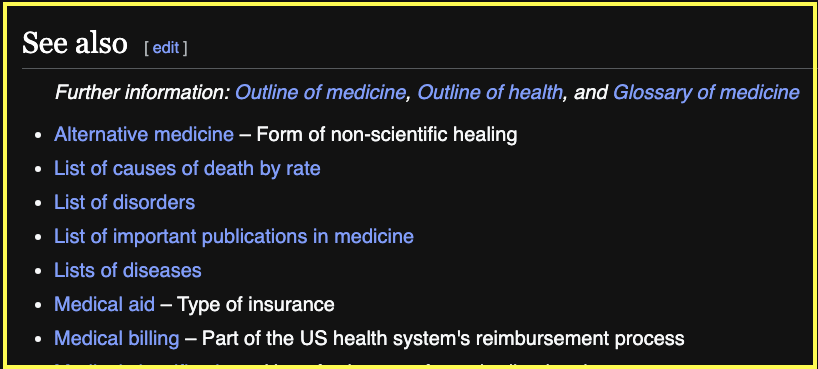

In [16]:
driver = setup_driver_wiki(download_dir_wiki)

for keyword in keywords_wiki:
    main_article_url = generate_wikipedia_url(keyword)
    extract_article_text_wiki(driver, main_article_url, download_dir_wiki)

    # Extract "See also" links from the main article
    driver.get(main_article_url)
    time.sleep(5)  # Wait for the page to load
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    see_also_section = soup.find(id="See_also")

    if see_also_section: #Extracting the related articles from the 'See also section'
        see_also_list = see_also_section.find_next('ul')
        if see_also_list:
            see_also_links = see_also_list.find_all('a', href=True)
            for link in see_also_links[:9]:  # Limit to 9 "See also" links
                article_url = f"https://en.wikipedia.org{link['href']}"
                extract_article_text_wiki(driver, article_url, download_dir_wiki)

driver.quit()
print("Finished downloading Wikipedia articles.")

Finished downloading Wikipedia articles.


________________________________________________________________________________________________________________________________________________

## 4. Download Healthline Articles
#### 4.a. Blog articlea on various health Topics . On their websites the topics are sorted from A-Z .
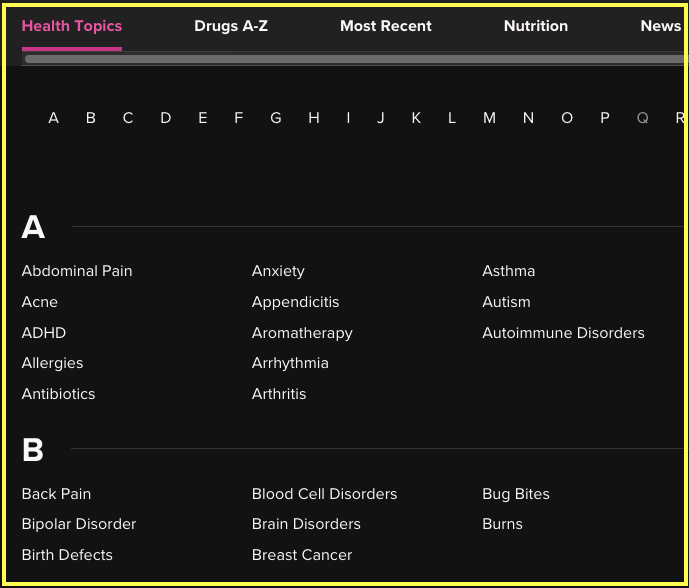

In [2]:
# Set the download directory for Healthline articles
download_dir = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/HEALTHLINE"  # Change this to the path where you want to save the text files

# Configure Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

# Set up the WebDriver
service = Service('/usr/local/bin/chromedriver')  # Change this to the correct path of your chromedriver
driver = webdriver.Chrome(service=service, options=chrome_options)
wait = WebDriverWait(driver, 20)

base_url = "https://www.healthline.com/directory/topics"
driver.get(base_url)

def save_article_text(topic_name, article_text):
    # Create a safe file name
    safe_topic_name = "".join(c for c in topic_name if c.isalnum() or c in (" ", "_")).rstrip()
    file_path = os.path.join(download_dir, f"{safe_topic_name}.txt")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(article_text)

In [3]:
# Get all topic links directly
topic_links = driver.find_elements(By.XPATH, "//a[contains(@class, 'css-14msgpg')]")
print("No of topic links found:", len(topic_links))

for i in range(len(topic_links)):
    retries = 3
    while retries > 0:
        try:
            # Refetch the topic links to avoid stale elements
            topic_links = driver.find_elements(By.XPATH, "//a[contains(@class, 'css-14msgpg')]")
            topic_link = topic_links[i]
            
            topic_url = topic_link.get_attribute('href')
            driver.get(topic_url)
            time.sleep(5)  # Wait for the page to load

            # Extract the article title
            title = driver.find_element(By.TAG_NAME, 'h1').text
            print(f"Processing article: {title}")

            # Use BeautifulSoup to parse the page content
            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Extract headings and paragraphs
            elements = soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p'])
            article_text = "\n".join([element.get_text() for element in elements if element.get_text().strip() != ""])

            # Save the article text to a file
            save_article_text(title, article_text)

            # Go back to the home page
            driver.get(base_url)
            time.sleep(5)  # Wait for the page to load
            break  # Exit the retry loop if successful
        except StaleElementReferenceException:
            retries -= 1
            print("Encountered StaleElementReferenceException. Retrying...")
            time.sleep(2)  # Short wait before retrying
            if retries == 0:
                print("Max retries reached. Skipping this link.")
        except NoSuchElementException as e:
            print(f"Error extracting article: {e}")
            break
        except Exception as e:
            print(f"Unexpected error: {e}")
            break

driver.quit()
print("Finished downloading all articles from Healthline.")

No of topic links found: 150
Processing article: What’s Causing Your Abdominal Pain and How to Treat It
Processing article: Everything You Want to Know About Acne
Processing article: Everything You Need to Know About ADHD
Processing article: Everything You Need to Know About Allergies
Processing article: How Do Antibiotics Work?
Processing article: Everything You Need to Know About Anxiety
Processing article: Everything You Need to Know About Appendicitis
Processing article: Aromatherapy Uses and Benefits
Processing article: Everything You Want to Know About Arrhythmia
Processing article: Arthritis
Processing article: Everything You Need to Know About Asthma: Symptoms, Types, Causes, Prevention, and More
Processing article: Everything You Need to Know About Autism Spectrum Disorder (ASD)
Processing article: Everything to Know About Autoimmune Diseases
Processing article: What Is Back Pain?
Processing article: Everything You Need to Know About Bipolar Disorder
Processing article: Birth 

#### 4.b. Blog articlea on various Medicines
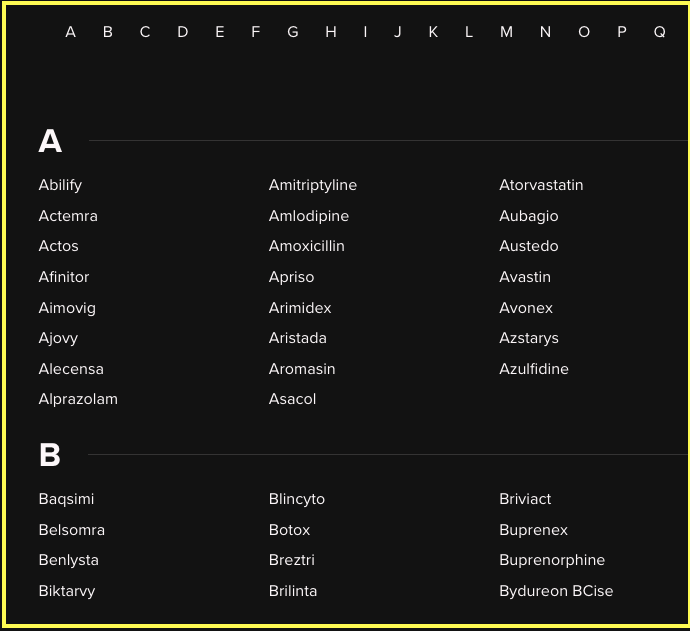

In [2]:
# Configure Chrome options
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
# Set up the WebDriver
service = Service('/usr/local/bin/chromedriver')  # Change this to the correct path of your chromedriver
driver = webdriver.Chrome(service=service, options=chrome_options)
wait = WebDriverWait(driver, 20)
base_url_2 = "https://www.healthline.com/directory/drugs-a-z"
driver.get(base_url_2)
download_dir = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/HEALTHLINE/DRUGS"

In [3]:
def save_article_text(topic_name, article_text):
    # Create a safe file name
    safe_topic_name = "".join(c for c in topic_name if c.isalnum() or c in (" ", "_")).rstrip()
    file_path = os.path.join(download_dir, f"{safe_topic_name}.txt")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(article_text)

In [4]:
# Get all topic links directly
topic_links = driver.find_elements(By.XPATH, "//a[contains(@class, 'css-14msgpg')]")
print("No of topic links found:", len(topic_links))

for i in range(1,100):
    retries = 3
    while retries > 0:
        try:
            # Refetch the topic links to avoid stale elements
            topic_links = driver.find_elements(By.XPATH, "//a[contains(@class, 'css-14msgpg')]")
            topic_link = topic_links[i]
            
            topic_url = topic_link.get_attribute('href')
            driver.get(topic_url)
            time.sleep(5)  # Wait for the page to load

            # Extract the article title
            title = driver.find_element(By.TAG_NAME, 'h1').text
            print(f"Processing article: {title}")

            # Use BeautifulSoup to parse the page content
            soup = BeautifulSoup(driver.page_source, 'html.parser')

            # Extract headings and paragraphs
            elements = soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p'])
            article_text = "\n".join([element.get_text() for element in elements if element.get_text().strip() != ""])

            # Save the article text to a file
            save_article_text(title, article_text)

            # Go back to the home page
            driver.get(base_url_2)
            time.sleep(5)  # Wait for the page to load
            break  # Exit the retry loop if successful
        except StaleElementReferenceException:
            retries -= 1
            print("Encountered StaleElementReferenceException. Retrying...")
            time.sleep(2)  # Short wait before retrying
            if retries == 0:
                print("Max retries reached. Skipping this link.")
        except NoSuchElementException as e:
            print(f"Error extracting article: {e}")
            break
        except Exception as e:
            print(f"Unexpected error: {e}")
            break

driver.quit()
print("Finished downloading all Drugs related data from Healthline.")

No of topic links found: 232
Processing article: All About Actemra
Processing article: All About Actos
Processing article: All About Afinitor
Processing article: All About Aimovig
Processing article: All About Ajovy
Processing article: All About Alecensa
Processing article: Alprazolam
Processing article: All About Amitriptyline Oral Tablet
Processing article: All About Amlodipine Oral Tablet
Processing article: All About Amoxicillin Oral Forms
Processing article: All About Apriso
Processing article: Arimidex Overview
Processing article: All About Aristada
Processing article: All About Aromasin
Processing article: All About Asacol HD
Processing article: All About Atorvastatin Oral Tablet
Processing article: All About Aubagio
Processing article: Austedo Overview: Side Effects, Uses, Dosage, and More
Processing article: All About Avastin
Processing article: All About Avonex
Processing article: All About Azstarys
Processing article: All About Azulfidine and Azulfidine EN-tabs
Processing ar

___________________________________________________________________________________________________________________________________________

## 5. Data Preprocessing

### 5.a. Loading and cleaning the data

In [4]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")
 
def load_text_files(folder_path): # for loading text data stored in various folders
    text_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text_data.append(file.read())
    return text_data

def load_pdf_files(folder_path):# for loading PDF data stored in various folders
    text_data = []
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(".pdf"):
                    try:
                        with open(os.path.join(subfolder_path, filename), 'rb') as file:
                            reader = PdfReader(file)
                            text = ''
                            for page_num in range(len(reader.pages)):
                                text += reader.pages[page_num].extract_text()
                            text_data.append(text)
                    except Exception as e:
                        print(f"Error reading {os.path.join(subfolder_path, filename)}: {e}")
                        continue
    return text_data

def clean_text(text): # for removing unnecessary chars
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def tokenize_text(text):
    return nltk.word_tokenize(text)

def segment_sentences(text):
    return nltk.sent_tokenize(text)

def split_text(text, max_length=100000):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manisunder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Folder paths
healthline_drugs_path = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/HEALTHLINE/DRUGS"
healthline_topics_path = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/HEALTHLINE/TOPICS"
wiki_path = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/WIKI"
pmc_papers_path = "/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/PMC_Papers"

In [9]:
# Load text and PDF data
healthline_drugs = load_text_files(healthline_drugs_path)
healthline_topics = load_text_files(healthline_topics_path)
wiki_articles = load_text_files(wiki_path)

In [8]:
#Loading PDF data
pmc_papers = load_pdf_files(pmc_papers_path)

Multiple definitions in dictionary at byte 0x16126 for key /MediaBox
Multiple definitions in dictionary at byte 0x16290 for key /MediaBox
Multiple definitions in dictionary at byte 0x1643a for key /MediaBox
Multiple definitions in dictionary at byte 0x1660c for key /MediaBox
Multiple definitions in dictionary at byte 0x1676e for key /MediaBox
Multiple definitions in dictionary at byte 0x168f8 for key /MediaBox
Multiple definitions in dictionary at byte 0x1bcc2 for key /MediaBox
Multiple definitions in dictionary at byte 0x1bf6b for key /MediaBox
Multiple definitions in dictionary at byte 0x1c13c for key /MediaBox
Multiple definitions in dictionary at byte 0x1c315 for key /MediaBox
Multiple definitions in dictionary at byte 0x1c4ee for key /MediaBox
Multiple definitions in dictionary at byte 0x1c757 for key /MediaBox
/opt/anaconda3/lib/python3.11/site-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-H not implemented yet
  warnings.warn(
/opt/anaconda3/lib/pyth

Error reading /Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/PMC_Papers/Patient Treatment Protocols/pone.0114098.pdf: '/Root'


Multiple definitions in dictionary at byte 0x25b13 for key /MediaBox
Multiple definitions in dictionary at byte 0x25e29 for key /MediaBox
Multiple definitions in dictionary at byte 0x26067 for key /MediaBox
Multiple definitions in dictionary at byte 0x2629d for key /MediaBox
Multiple definitions in dictionary at byte 0x2652e for key /MediaBox
Multiple definitions in dictionary at byte 0x26754 for key /MediaBox
Multiple definitions in dictionary at byte 0x268e2 for key /MediaBox
Multiple definitions in dictionary at byte 0x26aa8 for key /MediaBox
Multiple definitions in dictionary at byte 0x26d39 for key /MediaBox
Multiple definitions in dictionary at byte 0x26eef for key /MediaBox
Multiple definitions in dictionary at byte 0x270e8 for key /MediaBox
Multiple definitions in dictionary at byte 0x27371 for key /MediaBox
Multiple definitions in dictionary at byte 0x275e2 for key /MediaBox
Multiple definitions in dictionary at byte 0x2f68e for key /MediaBox
Multiple definitions in dictionary

In [20]:
with open('pmc_papers.json', 'w') as file:
    json.dump(pmc_papers, file)

In [10]:
with open('pmc_papers.json', 'r') as file:
    pmc_papers = json.load(file)

### Since the data is huge, we're saving the dataset in .json format which makes it easier while debugging or development

In [11]:
print("SUMMARY OF THE DATASET COLLECTED")
print("No. of Research articles extracted :", len(pmc_papers))
print("No. of Healthline articles extracted on Drugs:", len(healthline_drugs))
print("No. of Healthline blog articles extracted :", len(healthline_topics))
print("No. of Wikipedia articles extracted :", len(wiki_articles))

SUMMARY OF THE DATASET COLLECTED
No. of Research articles extracted : 3155
No. of Healthline articles extracted on Drugs: 90
No. of Healthline blog articles extracted : 126
No. of Wikipedia articles extracted : 72


## `NOTE:` The above is the entire corpus of data collected with decent diversity.

### 5.b. Data Preprocessing

In [12]:
# Combine all text data
all_text_data = healthline_drugs + healthline_topics + wiki_articles + pmc_papers

In [13]:
with open('all_text_data.json', 'w') as file:
    json.dump(all_text_data, file)

In [14]:
# Read segmented text data from a JSON file
with open('all_text_data.json', 'r') as file:
    all_text_data = json.load(file)

In [15]:
# Clean text data
cleaned_text_data = [clean_text(text) for text in all_text_data]

In [16]:
# Tokenize text data
tokenized_text_data = [tokenize_text(text) for text in cleaned_text_data]

In [17]:
# Segment sentences
segmented_text_data = [segment_sentences(text) for text in cleaned_text_data]

In [18]:
# Save segmented text data to a JSON file
with open('segmented_text_data.json', 'w') as file:
    json.dump(segmented_text_data, file)

In [4]:
# Read segmented text data from a JSON file
with open('segmented_text_data.json', 'r') as file:
    segmented_text_data = json.load(file)

#### The above step is done to bypass the data extraction steps which are time and resource intensive, in case of issues during the development. So we're storing the extracted data into a json file and reading it again.

In [30]:
# Create a DataFrame to visualize the text before and after preprocessing
df = pd.DataFrame({
    "Original Text": [text[:500] for text in all_text_data],
    "Cleaned Text": [text[:500] for text in cleaned_text_data],
    "Tokenized Text": [' '.join(tokens[:50]) for tokens in tokenized_text_data],
    "Segmented Sentences": [' '.join(sentences[:5]) for sentences in segmented_text_data],
    #"Named Entities": [str(entities[:5]) for entities in entity_recognized_data]
})

In [31]:
# Display the DataFrame
print("Preprocessing complete. Data displayed.")
print("\n")
display(df)


Preprocessing complete. Data displayed.




,Original Text,Cleaned Text,Tokenized Text,Segmented Sentences
0,All About Genvoya\nBoxed warning: Risk of wors...,all about genvoya boxed warning risk of worsen...,all about genvoya boxed warning risk of worsen...,all about genvoya boxed warning risk of worsen...
1,All About Humalog\nHumalog (insulin lispro) is...,all about humalog humalog insulin lispro is a ...,all about humalog humalog insulin lispro is a ...,all about humalog humalog insulin lispro is a ...
2,All About Lantus \nWhat is Lantus?\nIf you hav...,all about lantus what is lantus if you have di...,all about lantus what is lantus if you have di...,all about lantus what is lantus if you have di...
3,All About Fluoxetine Oral Capsule\nBoxed warni...,all about fluoxetine oral capsule boxed warnin...,all about fluoxetine oral capsule boxed warnin...,all about fluoxetine oral capsule boxed warnin...
4,All About Ingrezza\nIngrezza (valbenazine) is ...,all about ingrezza ingrezza valbenazine is a p...,all about ingrezza ingrezza valbenazine is a p...,all about ingrezza ingrezza valbenazine is a p...
...,...,...,...,...
3438,Imaging as a diagnostic and therapeutic tool i...,imaging as a diagnostic and therapeutic tool i...,imaging as a diagnostic and therapeutic tool i...,imaging as a diagnostic and therapeutic tool i...
3439,Nanoparticle contrast agents for X-ray imaging...,nanoparticle contrast agents for xray imaging ...,nanoparticle contrast agents for xray imaging ...,nanoparticle contrast agents for xray imaging ...
3440,Iron oxide nanoparticle agglomeration influenc...,iron oxide nanoparticle agglomeration influenc...,iron oxide nanoparticle agglomeration influenc...,iron oxide nanoparticle agglomeration influenc...
3441,ZK[KF ZIN FZ\OIS K\nFz{vow qu€t{z {qrozottm r~...,zkkf zin fzois k fzvow qutz qrozottm roy wwq t...,zkkf zin fzois k fzvow qutz qrozottm roy wwq t...,zkkf zin fzois k fzvow qutz qrozottm roy wwq t...


In [32]:
print("Original Text: ", "\n",df['Original Text'][0], "\n")
print("Cleaned Text:", "\n",df['Cleaned Text'][0], "\n")
print("Tokenized Text:", "\n", df['Tokenized Text'][0], "\n")
print("Segmented Sentences:", "\n",df['Segmented Sentences'][0], "\n")

Original Text:  
 All About Genvoya
Boxed warning: Risk of worsening hepatitis B infection
Genvoya has a boxed warning about the risk of worsening hepatitis B infection after stopping treatment. A boxed warning is a serious warning from the Food and Drug Administration (FDA).Before you begin taking Genvoya, your doctor will test you for hepatitis B. If you have hepatitis B and need to stop taking Genvoya, your infection may get worse after stopping treatment. Your doctor will closely monitor your liver health for 

Cleaned Text: 
 all about genvoya boxed warning risk of worsening hepatitis b infection genvoya has a boxed warning about the risk of worsening hepatitis b infection after stopping treatment a boxed warning is a serious warning from the food and drug administration fdabefore you begin taking genvoya your doctor will test you for hepatitis b if you have hepatitis b and need to stop taking genvoya your infection may get worse after stopping treatment your doctor will closely m

____________________________________________________________________________________________________________________________________________

## 6. Fetching model `RoBERTa` from Hugging face for the task

In [1]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
# Load the tokenizer and model
tokenizer_roberta = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
model_roberta = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")

### 6.a. Using another transformers model to generate Q and As i.e. training data for RoBERTa from the text from our dataset

### We chose to use another LLM to generate questions because-
1. To generate the dataset in the form of `context`, `question` and `answer` specific to the use case i.e. to train a QA bot.
2. Manually writing questions is tedious filled with bias and lack of proper domain knowledge. Hence we  leveraged other models specifically designed for QA tasks to generate this training data

In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('valhalla/t5-small-e2e-qg',legacy=False)
model = T5ForConditionalGeneration.from_pretrained('valhalla/t5-small-e2e-qg')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
def generate_questions(context):
    input_text = "generate question: " + context
    encoding = tokenizer.encode_plus(input_text, return_tensors="pt")
    input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]

    outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
    questions = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Split the questions by <sep> and strip whitespace
    questions = [q.strip() for q in questions.split('<sep>') if q.strip()]
    return questions

### 6.b Validation check to see of the model is solving the purpose, i.e. giving questions based on the context

In [24]:
# Example usage
context = "Hypertension, also known as high blood pressure, is a condition in which the force of the blood against the artery walls is too high. It is often caused by lifestyle factors and can lead to serious health issues such as heart disease and stroke."
question = generate_questions(context)

In [25]:
print(f"Context:\n {context} \n")
print(f"Question:\n {question}")

Context:
 Hypertension, also known as high blood pressure, is a condition in which the force of the blood against the artery walls is too high. It is often caused by lifestyle factors and can lead to serious health issues such as heart disease and stroke. 

Question:
 ['What is a condition called that is too high?', 'What is the force of the blood against the artery walls?', 'What is the cause of hypertension?', 'What is the cause of hypertension?']


In [41]:
# Function to process each context
def process_context(context):
    if isinstance(context, list):
        context = ' '.join(context)

    # Truncate context to ensure it's within the model's max length
    context = context[:512]  # Adjust this value as needed

    questions = generate_questions(context)
    local_data = {'question': [], 'context': [], 'answers': []}

    for question in questions:
        answer = question  # Using the question itself as a placeholder for the answer
        answer_start = context.find(answer)
        if answer_start != -1:
            local_data['question'].append(question)
            local_data['context'].append(context)
            local_data['answers'].append({'text': [answer], 'answer_start': [answer_start]})

    return local_data

### 6.c. We used the valhalla/t5-small-e2e-qg QA model to give us questions to train the RoBERTa model i.e. prepare the training data.

In [42]:
# Load segmented text data from a JSON file
with open('all_text_data.json', 'r') as file:
    segmented_text_data = json.load(file)

In [43]:
# Initialize data dictionary
data = {'question': [], 'context': [], 'answers': []}

# Use concurrent futures to parallelize processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_context, segmented_text_data), total=len(segmented_text_data)))

# Combine results
for result in results:
    data['question'].extend(result['question'])
    data['context'].extend(result['context'])
    data['answers'].extend(result['answers'])

100%|███████████████████████████████████████| 3443/3443 [26:39<00:00,  2.15it/s]


In [47]:
# Verify the data
print("Sample questions:", data['question'][0])
print("Sample contexts:", data['context'][0])
print("Sample answers:", data['answers'][0])

Sample questions: What is Lantus?
Sample contexts: All About Lantus 
What is Lantus?
If you have diabetes, your doctor may prescribe Lantus for you.
It’s a prescription drug that’s used to help manage blood sugar levels in:
Lantus isn’t used to treat diabetic ketoacidosis (DKA). (DKA is a serious complication of diabetes that causes acid to build up in the blood.)
To learn more about diabetes, see the “What is Lantus used for?” section below.
Lantus basics and classification
Lantus is classified as a long-acting insulin. It contains the active drug insulin 
Sample answers: {'text': ['What is Lantus?'], 'answer_start': [18]}


In [30]:
with open("processed_data.json", "w") as f:
    json.dump(data, f)

### 6.d Training the model

In [48]:
# Load the processed data
with open("processed_data.json", "r") as f:
    data = json.load(f)

In [49]:
# Convert the data into a Dataset
dataset = Dataset.from_dict(data)

In [50]:
# Tokenize the dataset directly
tokenized_data = tokenizer_roberta(
    data["question"],
    data["context"],
    max_length=512,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
)

In [51]:
# Convert tokenized data tensors to lists
input_ids_list = tokenized_data["input_ids"].tolist()
attention_mask_list = tokenized_data["attention_mask"].tolist()

# Add tokenized data back to the dataset
dataset = dataset.add_column("input_ids", input_ids_list)
dataset = dataset.add_column("attention_mask", attention_mask_list)

In [52]:
# Ensuring start_positions and end_positions are correctly set as per the token limitations of the model
def set_positions(example):
    example["start_positions"] = []
    example["end_positions"] = []
    for answer in example["answers"]:
        start = answer["answer_start"][0]
        end = start + len(answer["text"][0])
        if start >= 512:
            start = 511
        if end >= 512:
            end = 511
        example["start_positions"].append(start)
        example["end_positions"].append(end)
    return example


dataset = dataset.map(set_positions, batched=True)

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

In [53]:
# Split the dataset into training and validation sets
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

In [55]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Reduced batch size
    per_device_eval_batch_size=4,  # Reduced batch size
    num_train_epochs=30,  # Increased number of epochs
    weight_decay=0.01,
    logging_dir='/Users/manisunder/Desktop/DEGREES & CERTS/MTECH/AI-ML/SEM-3/NLP Apps/Assignment 1/logs',
    logging_steps=10,  # Log training loss every 10 steps
    save_strategy="epoch",  # Save the model at the end of each epoch
)

In [56]:
# Use a DataCollator to handle input data during training
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

- We used data_collator to handle the dynamic padding of input sequences during batching,
- This ensures they are of uniform length whichimproves efficiency and compatibility with the model during training and evaluation.

In [57]:
# Create a Trainer instance
trainer = Trainer(
    model=model_roberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

In [58]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.001088
2,0.164700,0.001503
3,0.164700,0.004675
4,0.006000,0.000107
5,0.006000,0.000553
6,0.035500,0.000608
7,0.035500,0.001239
8,0.011200,0.000979
9,0.011200,0.000096
10,0.000400,0.000042


TrainOutput(global_step=150, training_loss=0.014681840541694934, metrics={'train_runtime': 69.5649, 'train_samples_per_second': 7.331, 'train_steps_per_second': 2.156, 'total_flos': 133261345935360.0, 'train_loss': 0.014681840541694934, 'epoch': 30.0})

### 6.e Saving the model

In [59]:
from transformers import AutoModelForQuestionAnswering

# Save the trained model and tokenizer
model.save_pretrained("./fine_tuned_roberta")
tokenizer.save_pretrained("./fine_tuned_roberta")

('./fine_tuned_roberta/tokenizer_config.json',
 './fine_tuned_roberta/special_tokens_map.json',
 './fine_tuned_roberta/spiece.model',
 './fine_tuned_roberta/added_tokens.json')

### 6.f Model Evaluation

In [62]:
from datasets import load_metric
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the SQuAD metric
squad_metric = load_metric("squad")

# Function to compute metrics
def compute_metrics(pred):
    start_preds = np.argmax(pred.predictions[0], axis=1)
    end_preds = np.argmax(pred.predictions[1], axis=1)
    
    # Extract the contexts from the validation dataset
    contexts = val_dataset["context"]
    
    # Prepare the references and predictions
    references = [{"id": str(i), "answers": {"text": [val_dataset["answers"][i]["text"][0]], "answer_start": [val_dataset["answers"][i]["answer_start"][0]]}} for i in range(len(val_dataset))]
    predictions = [{"id": str(i), "prediction_text": contexts[i][start_preds[i]:end_preds[i]+1]} for i in range(len(val_dataset))]
    
    squad_results = squad_metric.compute(predictions=predictions, references=references)
    
    # Calculate additional metrics
    true_starts = [ref["answers"]["answer_start"][0] for ref in references]
    true_ends = [ref["answers"]["answer_start"][0] + len(ref["answers"]["text"][0]) for ref in references]
    
    precision = precision_score(true_starts, start_preds, average='micro')
    recall = recall_score(true_starts, start_preds, average='micro')
    f1 = f1_score(true_starts, start_preds, average='micro')
    accuracy = accuracy_score(true_starts, start_preds)
    
    metrics = {
        "squad": squad_results,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }
    
    return metrics

# Evaluate the model
results = trainer.evaluate()

# Compute metrics
predictions = trainer.predict(val_dataset)
metrics = compute_metrics(predictions)


print("Precision: {:.4f}".format(metrics["precision"]))
print("Recall: {:.4f}".format(metrics["recall"]))
print("F1 Score: {:.4f}".format(metrics["f1"]))
print("Accuracy: {:.4f}".format(metrics["accuracy"]))


SQuAD Results: {'exact_match': 0.0, 'f1': 90.0}
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000
